# ---------  CNN Image Classification -------

Goal 1: Identifying data from CBIS-DDSM as being 'Malignant' or 'Benign' using a binary classification pipeline.

Goal 2: Comparing the performance of models that are developed using the entirety of the CBIS DDSM's full mammography images or a curated subset of images selected as to improve generalisability.

# Installing Dependencies and Setup

In [ ]:
#!pip install --upgrade pip
#!pip install tensorflow
#!pip install opencv-python
#!pip install tensorflow-gpu
#!conda install -c anaconda tensorflow-gpu keras-gpu
#!pip install matplotlib

import tensorflow as tf   #Core driver of this method
import os                 #Used to navigate through file structures
import keras
import matplotlib
import cv2
import imghdr
import numpy as np

from keras.layers import Dense
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.constraints import max_norm

from matplotlib import pyplot as plt

from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.constraints import max_norm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!python3 -VV
keras.__version__

Python 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]


'2.13.1'

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
#as a check
cpus = tf.config.experimental.list_physical_devices('CPU')
cpus

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]



---



# Data Input

In [ ]:
data_path_subset = '/content/drive/MyDrive/CNN_subset'
data_path_full = '/content/drive/MyDrive/CNN_full'

In [ ]:
print(os.listdir(data_path_subset))
print(os.listdir(data_path_full))

['Malignant', 'Benign']
['Benign', 'Malignant']


In [ ]:
image_format = ['png']

In [ ]:
img = cv2.imread(os.path.join('/content/drive/MyDrive/CNN_subset','Malignant','aa2068.png'))
img.shape

(256, 256, 3)

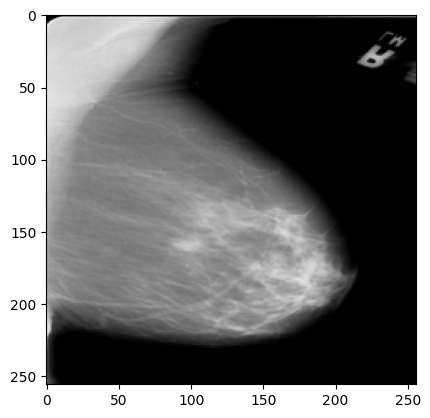

In [ ]:
plt.imshow(img)

In [ ]:
img = cv2.imread(os.path.join('/content/drive/MyDrive/CNN_full','Malignant','Calc-Test_P_00127_RIGHT_CC.png'))
img.shape

(256, 256, 3)

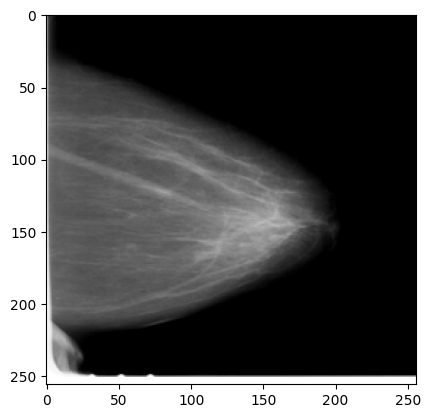

In [ ]:
plt.imshow(img)

In [ ]:
img2 = cv2.imread(os.path.join('/content/drive/MyDrive/CNN_subset','Benign','a3739.png'))

In [ ]:
img2.shape

(256, 256, 3)

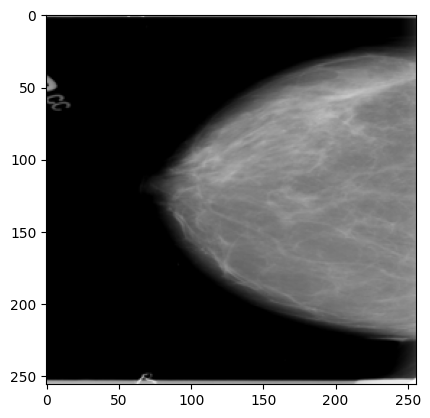

In [ ]:
plt.imshow(img2)

In [ ]:
img2 = cv2.imread(os.path.join('/content/drive/MyDrive/CNN_full','Benign','Calc-Test_P_00038_LEFT_CC.png'))

In [ ]:
img2.shape

(256, 256, 3)

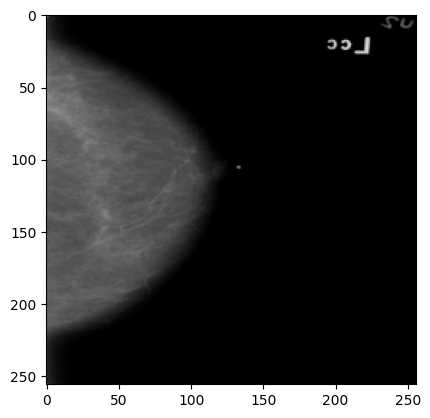

In [ ]:
plt.imshow(img2)



---



# Load Data

In [ ]:
data_subset = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/subset_data_amended', class_names=['benign','malignant'],shuffle=True, seed=42, color_mode='rgb')

Found 2372 files belonging to 2 classes.


In [ ]:
data_full = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/CNN_full', class_names=['Benign','Malignant'],shuffle=True, seed=42, color_mode='rgb')

Found 3103 files belonging to 2 classes.


In [ ]:
data_subset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
data_full

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
#tf.keras.utils.image_dataset_from_directory?? #uncomment to view the default values, we have batch size 32 by default.

In [ ]:
len(data_subset)

75

In [ ]:
len(data_full)

97

In [ ]:
data_subset_iterator = data_subset.as_numpy_iterator() #convert this generator using a numpy interator so we may access it
data_subset_iterator

In [ ]:
data_full_iterator = data_full.as_numpy_iterator() #convert this generator using a numpy interator so we may access it
data_full_iterator

In [ ]:
data_subset_batch = data_subset_iterator.next()

In [ ]:
data_full_batch = data_full_iterator.next()

In [ ]:
print(len(data_subset_batch))
print(len(data_full_batch))

2
2


In [ ]:
print(len(data_subset_batch[0]))
print(data_subset_batch[0].shape) # 32 256x images

32
(32, 256, 256, 3)


In [ ]:
print(len(data_full_batch[0]))
print(data_full_batch[0].shape) # 32 256x images

32
(32, 256, 256, 3)


In [ ]:
print(len(data_subset_batch[1]))
print(data_subset_batch[1].shape)
data_subset_batch[1] #uncomment to view the array

32
(32,)


array([0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 0], dtype=int32)

In [ ]:
print(len(data_full_batch[1]))
print(data_full_batch[1].shape)
data_full_batch[1] #uncomment to view the array

32
(32,)


array([1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1], dtype=int32)

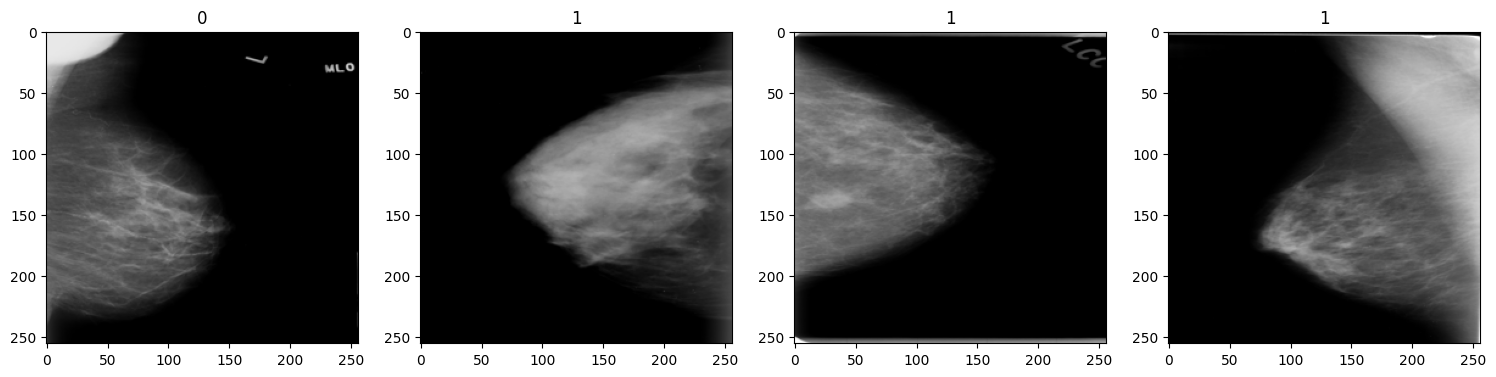

In [ ]:
fix, ax = plt.subplots(ncols=4, figsize=(18.5,18.5))
for idx, img in enumerate(data_subset_batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(data_subset_batch[1][idx])

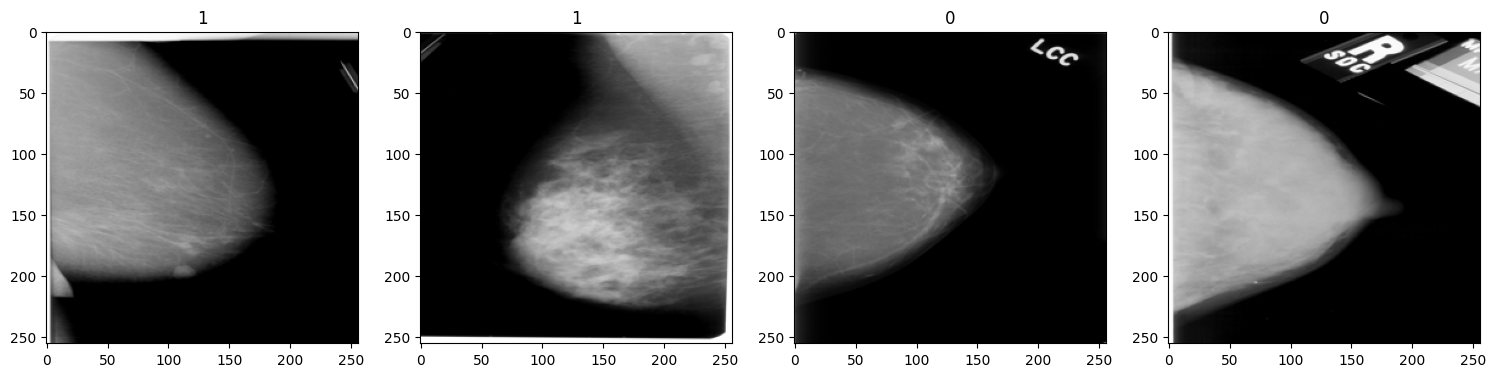

In [ ]:
fix, ax = plt.subplots(ncols=4, figsize=(18.5,18.5))
for idx, img in enumerate(data_full_batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(data_full_batch[1][idx])



---



# Preprocessing

First major step we're going to perform here is normalising our data, in so much that we reduce our numpy arrays to values between 0 and 1. This will reduce the time it takes to perform the backend calcualtions.

In [ ]:
print(data_subset_batch[0].max())
print(data_subset_batch[0].min())

255.0
0.0


In [ ]:
print(data_full_batch[0].max())
print(data_full_batch[0].min())

255.0
0.0


In [ ]:
#Scaling the x variable below
#x representing features, y = labels, we don't want to scale the numerical labels but we want the values to be smaller in magnitude across the board
scaled_data_subset = data_subset.map(lambda x,y: (x/255, y))

In [ ]:
scaled_data_full = data_full.map(lambda x,y: (x/255, y))

In [ ]:
#We can see that the data has been resized down to between 1 and 0
scaled_iter_subset = scaled_data_subset.as_numpy_iterator()
print(scaled_iter_subset.next()[0].min())
print(scaled_iter_subset.next()[0].max())

0.0
1.0


In [ ]:
scaled_iter_full = scaled_data_full.as_numpy_iterator()
print(scaled_iter_full.next()[0].min())
print(scaled_iter_full.next()[0].max())

0.0
1.0


In [ ]:
batch_subset = scaled_iter_subset.next()
batch_full = scaled_iter_full.next()

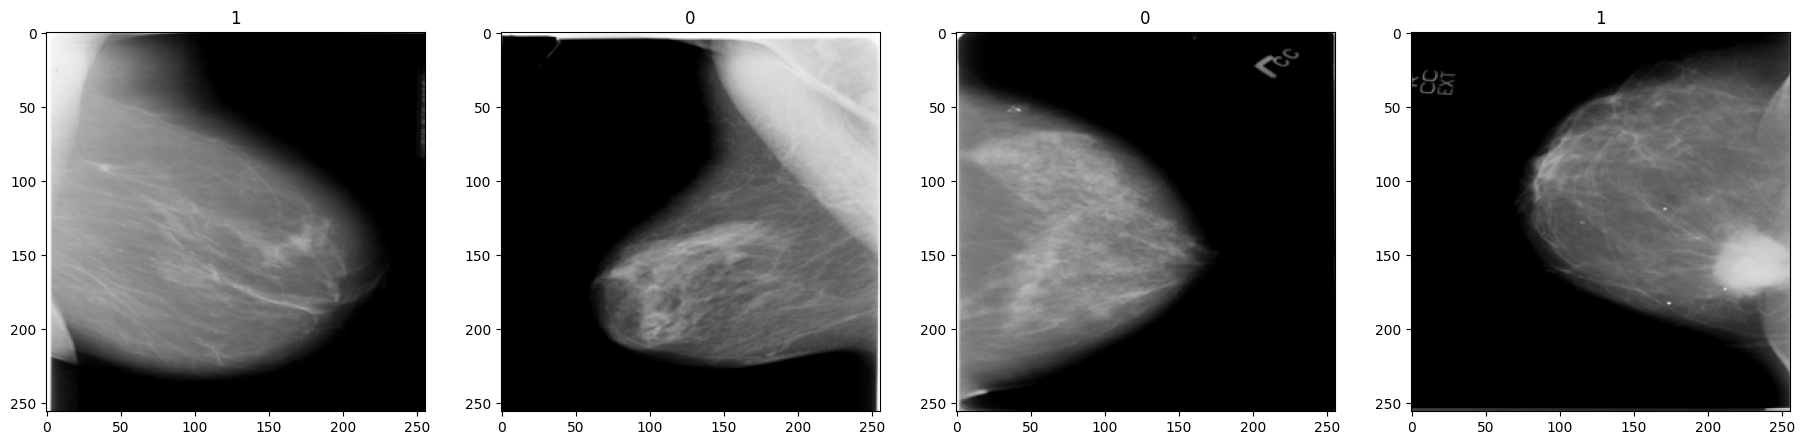

In [ ]:
fix, ax = plt.subplots(ncols=4, figsize=(22.5,22.5))
for idx, img in enumerate(batch_subset[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch_subset[1][idx])

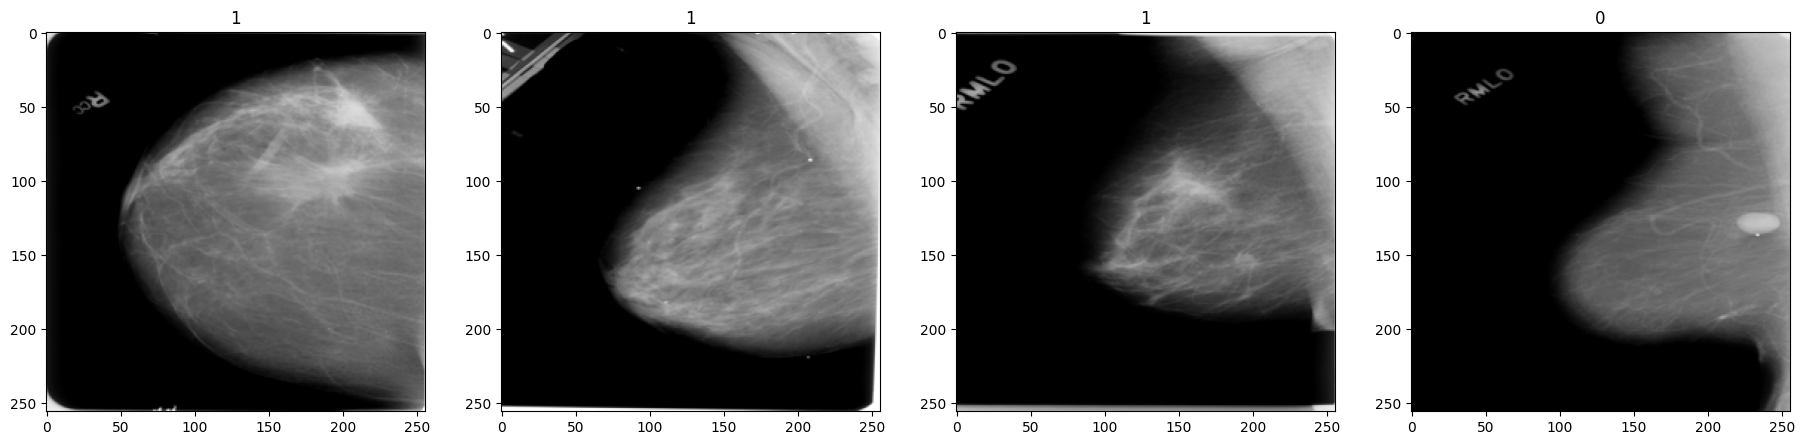

In [ ]:
fix, ax = plt.subplots(ncols=4, figsize=(22.5,22.5))
for idx, img in enumerate(batch_full[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch_full[1][idx])

In [ ]:
print(len(scaled_data_full))

97


In [ ]:
print(len(scaled_data_subset))

75


In [ ]:
#subset
train_size_subset = int(len(scaled_data_subset)*.7)+2 #% split missed 2, placing remaining batches into training
val_size_subset = int(len(scaled_data_subset)*.2)
test_size_subset = int(len(scaled_data_subset)*.1)

In [ ]:
#full
train_size_full = int(len(scaled_data_full)*.7)+2 #% split missed 2, placing remaining batches into training
val_size_full = int(len(scaled_data_full)*.2)
test_size_full = int(len(scaled_data_full)*.1)

In [ ]:
#subset
train_sub = scaled_data_subset.take(train_size_subset)
val_sub = scaled_data_subset.skip(train_size_subset).take(val_size_subset)              #skip batches that we have already assigned to train
test_sub = scaled_data_subset.skip(train_size_subset+val_size_subset).take(test_size_subset)   #skip batches that we have already assigned to train and val

In [ ]:
#full
train_full = scaled_data_full.take(train_size_full)
val_full = scaled_data_full.skip(train_size_full).take(val_size_full)              #skip batches that we have already assigned to train
test_full = scaled_data_full.skip(train_size_full+val_size_full).take(test_size_full)   #skip batches that we have already assigned to train and val

In [ ]:
print(len(train_sub))
print(len(val_sub))
print(len(test_sub))

54
15
6


In [ ]:
print(len(train_full))
print(len(val_full))
print(len(test_full))

69
19
9


In [ ]:
#Now we have assigned 9,2,1 for all 3 subgroups successfully



---



# Deep Learning Models

Creating the basis for the model



In [ ]:
# Create a Sequential model
model = Sequential()

# 1st layer: Input layer
model.add(Conv2D(32, (3, 3), strides=1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())
model.add(BatchNormalization())

# 2nd layer
model.add(Conv2D(32, (3, 3), strides=1, activation='relu', kernel_regularizer=regularizers.l2(0.02), kernel_constraint=max_norm(4)))
model.add(MaxPooling2D())
model.add(BatchNormalization())

# Flatten layer to convert data to a 1D format
model.add(Flatten())

# Connected layer
model.add(Dense(256,activation='relu',kernel_regularizer=regularizers.l2(0.02),kernel_constraint=max_norm(4)))

# Dropout layer to reduce overfitting
model.add(Dropout(0.6)) #~.7 using 0.5 - consider this if performance dips# decent performance with 0.6

# Output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

In [ ]:
adam = Adam(learning_rate=0.00001)
model.compile(optimizer=adam, loss=tf.losses.BinaryCrossentropy(), metrics=['Recall','Precision','accuracy', 'AUC'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 127, 127, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                        



---



# Model Training and Evaluation - Full Dataset

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode ='min', patience=2)
hist = model.fit(train_full, epochs=150, validation_data=val_full, callbacks=[callback],verbose=0)

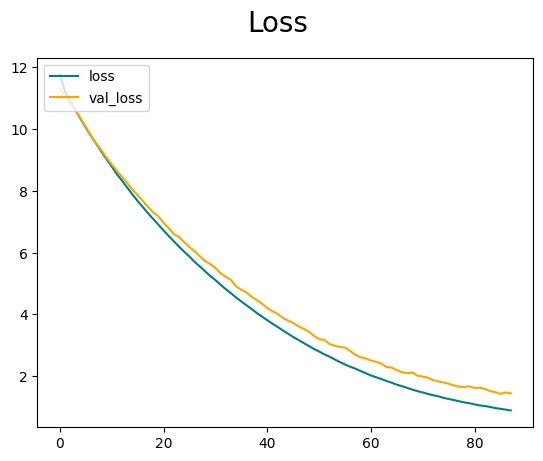

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()


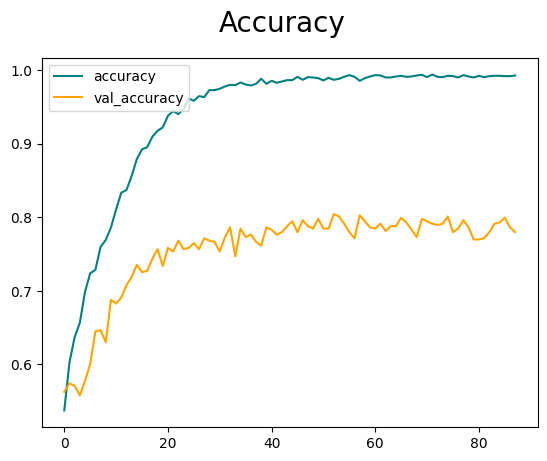

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

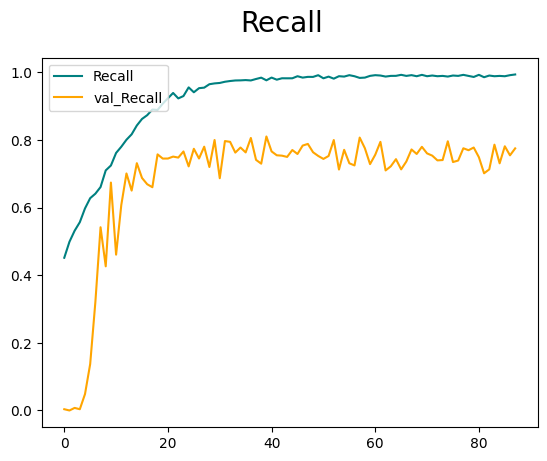

In [ ]:
fig = plt.figure()
plt.plot(hist.history['recall'], color='teal', label='Recall')
plt.plot(hist.history['val_recall'], color='orange', label='val_Recall')
fig.suptitle('Recall', fontsize=20)
plt.legend(loc="upper left")
plt.show()

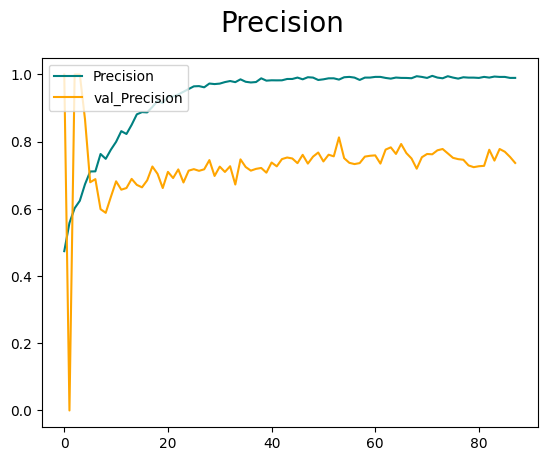

In [ ]:
fig = plt.figure()
plt.plot(hist.history['precision'], color='teal', label='Precision')
plt.plot(hist.history['val_precision'], color='orange', label='val_Precision')
fig.suptitle('Precision', fontsize=20)
plt.legend(loc="upper left")
plt.show()

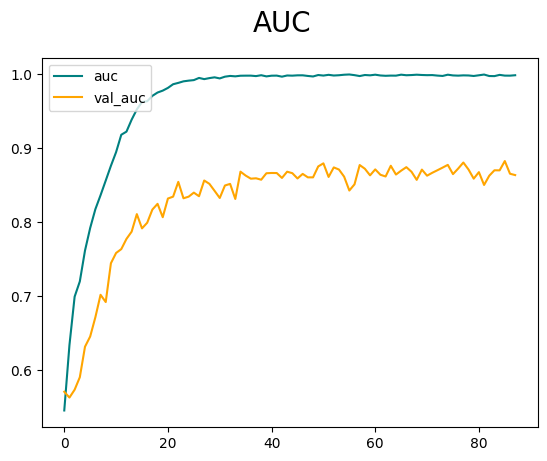

In [ ]:
fig = plt.figure()
plt.plot(hist.history['auc'], color='teal', label='auc')
plt.plot(hist.history['val_auc'], color='orange', label='val_auc')
fig.suptitle('AUC', fontsize=20)
plt.legend(loc="upper left")
plt.show()



---



# Evaluation Full Dataset Model

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, AUC

# Classification Report and Confusion Matrix

1/1 [==============================] - 0s 499ms/step


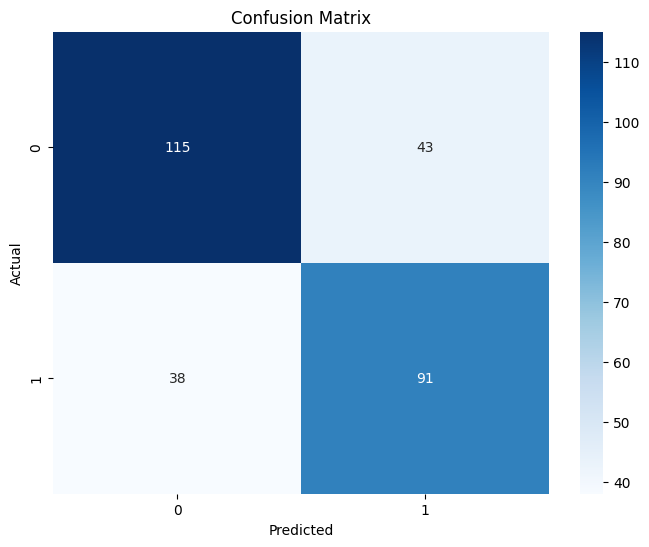

              precision    recall  f1-score   support

           0       0.75      0.73      0.74       158
           1       0.68      0.71      0.69       129

    accuracy                           0.72       287
   macro avg       0.72      0.72      0.72       287
weighted avg       0.72      0.72      0.72       287



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Initialize lists to store true labels and predictions
true_labels = []
predicted_labels = []

for batch in test_full.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    yhat_binary = (yhat > 0.5).astype(int)  # Binarize predictions using 0.5 as threshold

    true_labels.extend(y)
    predicted_labels.extend(yhat_binary)

# Generate and display the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Generate and print the classification report
report = classification_report(true_labels, predicted_labels)
print(report)


# ROC and AUC - Full

1/1 [==============================] - 0s 39ms/step


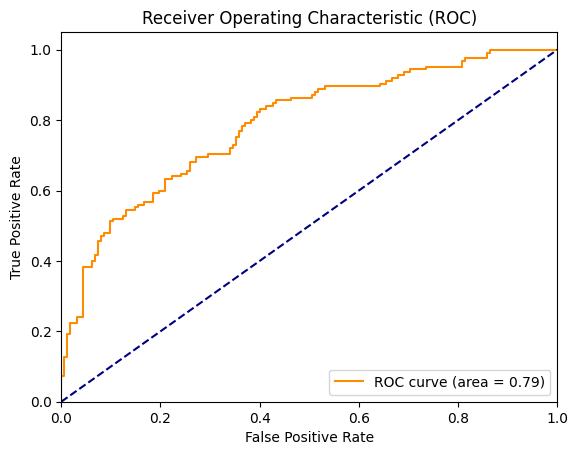

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming the model and test dataset is already defined
all_y = []
all_yhat = []

# Collecting ground truth and predictions
for batch in test_full.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    all_y.extend(y)
    all_yhat.extend(yhat)

# Convert to arrays
all_y = np.array(all_y).ravel()
all_yhat = np.array(all_yhat).ravel()

# Check the lengths
if len(all_y) != len(all_yhat):
    min_len = min(len(all_y), len(all_yhat))
    all_y = all_y[:min_len]
    all_yhat = all_yhat[:min_len]

# Filter out abnormal values
finite_indices = np.where(np.isfinite(all_y) & np.isfinite(all_yhat))
all_y = all_y[finite_indices]
all_yhat = all_yhat[finite_indices]

# Compute ROC and AUC
fpr, tpr, thresholds = roc_curve(all_y, all_yhat)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()



---



# Model Training and Evaluation - Subset

In [ ]:
# Create a Sequential model
model_sub = Sequential()

# 1st layer: Input layer
model_sub.add(Conv2D(32, (3, 3), strides=1, activation='relu', input_shape=(256, 256, 3)))
model_sub.add(MaxPooling2D())
model_sub.add(BatchNormalization())

# 2nd layer
model_sub.add(Conv2D(32, (3, 3), strides=1, activation='relu', kernel_regularizer=regularizers.l2(0.02), kernel_constraint=max_norm(4)))
model_sub.add(MaxPooling2D())
model_sub.add(BatchNormalization())

# Flatten layer to convert data to a 1D format
model_sub.add(Flatten())

# Connected layer
model_sub.add(Dense(256,activation='relu',kernel_regularizer=regularizers.l2(0.02),kernel_constraint=max_norm(4)))

# Dropout layer to reduce overfitting
model_sub.add(Dropout(0.6)) #~.7 using 0.5 - consider this if performance dips# decent performance with 0.6

# Output layer with sigmoid activation for binary classification
model_sub.add(Dense(1, activation='sigmoid'))

In [ ]:
adam = Adam(learning_rate=0.00001)
model_sub.compile(optimizer=adam, loss=tf.losses.BinaryCrossentropy(), metrics=['Recall','Precision','accuracy', 'AUC'])

In [ ]:
model_sub.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 batch_normalization_2 (Bat  (None, 127, 127, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                      

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode ='min', patience=2)
hist2 = model_sub.fit(train_sub, epochs=150, validation_data=val_sub, callbacks=[callback],verbose=0)

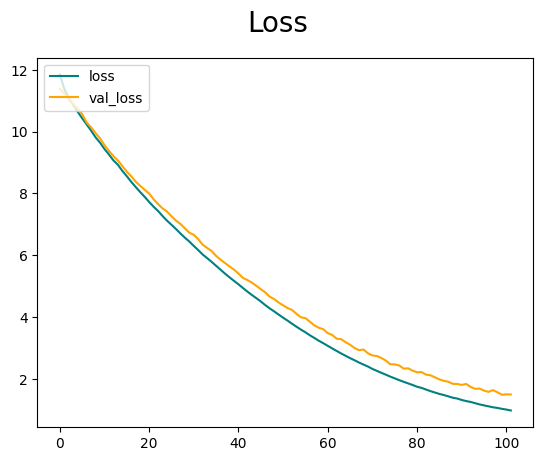

In [ ]:
fig = plt.figure()
plt.plot(hist2.history['loss'], color='teal', label='loss')
plt.plot(hist2.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()


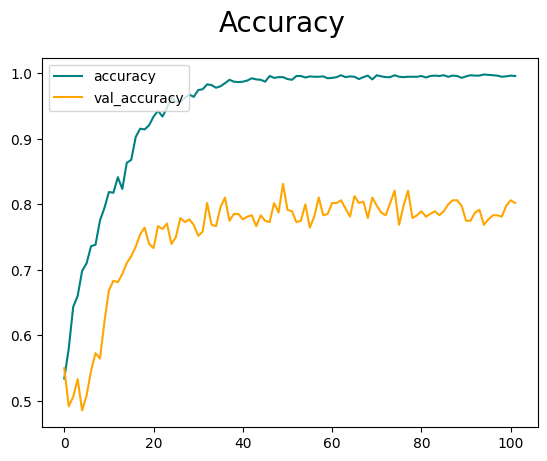

In [ ]:
fig = plt.figure()
plt.plot(hist2.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist2.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

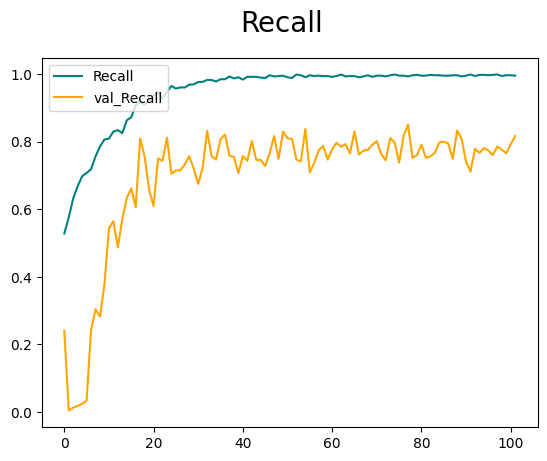

In [ ]:
fig = plt.figure()
plt.plot(hist2.history['recall'], color='teal', label='Recall')
plt.plot(hist2.history['val_recall'], color='orange', label='val_Recall')
fig.suptitle('Recall', fontsize=20)
plt.legend(loc="upper left")
plt.show()

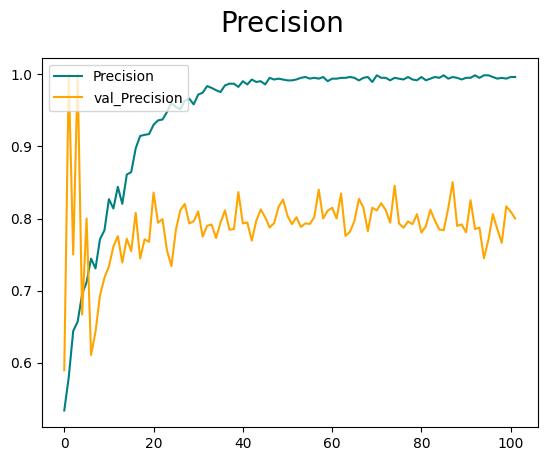

In [ ]:
fig = plt.figure()
plt.plot(hist2.history['precision'], color='teal', label='Precision')
plt.plot(hist2.history['val_precision'], color='orange', label='val_Precision')
fig.suptitle('Precision', fontsize=20)
plt.legend(loc="upper left")
plt.show()

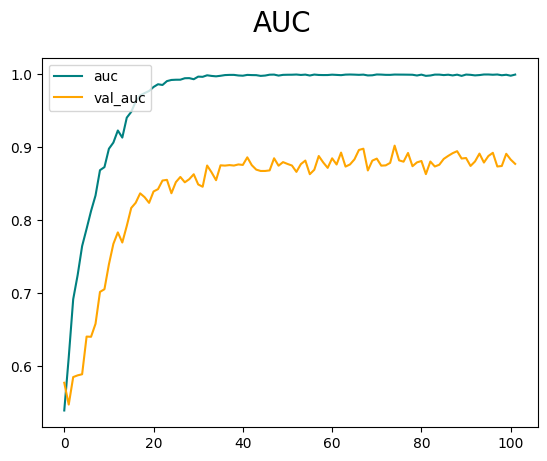

In [ ]:
fig = plt.figure()
plt.plot(hist2.history['auc'], color='teal', label='auc')
plt.plot(hist2.history['val_auc'], color='orange', label='val_auc')
fig.suptitle('AUC', fontsize=20)
plt.legend(loc="upper left")
plt.show()

#Evaluation Subset Dataset Model

1/1 [==============================] - 0s 212ms/step


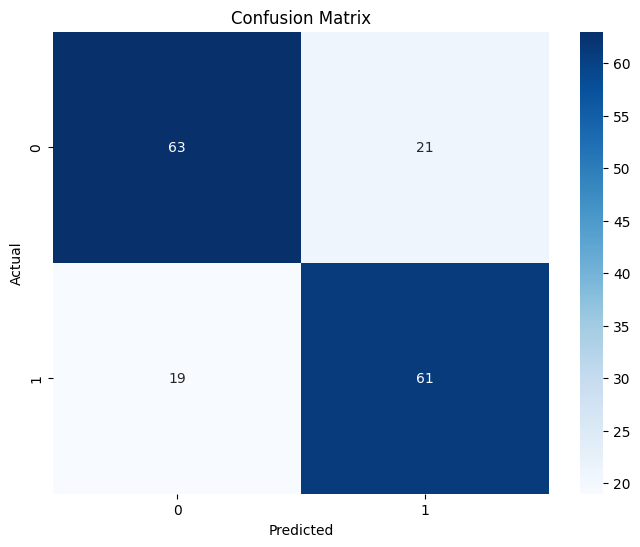

              precision    recall  f1-score   support

           0       0.77      0.75      0.76        84
           1       0.74      0.76      0.75        80

    accuracy                           0.76       164
   macro avg       0.76      0.76      0.76       164
weighted avg       0.76      0.76      0.76       164



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Initialize lists to store true labels and predictions
true_labels = []
predicted_labels = []

for batch in test_sub.as_numpy_iterator():
    X, y = batch
    yhat = model_sub.predict(X)
    yhat_binary = (yhat > 0.5).astype(int)  # Binarize predictions using 0.5 as threshold

    true_labels.extend(y)
    predicted_labels.extend(yhat_binary)

# Generate and display the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Generate and print the classification report
report = classification_report(true_labels, predicted_labels)
print(report)


# ROC and AUC - Subset



1/1 [==============================] - 0s 21ms/step


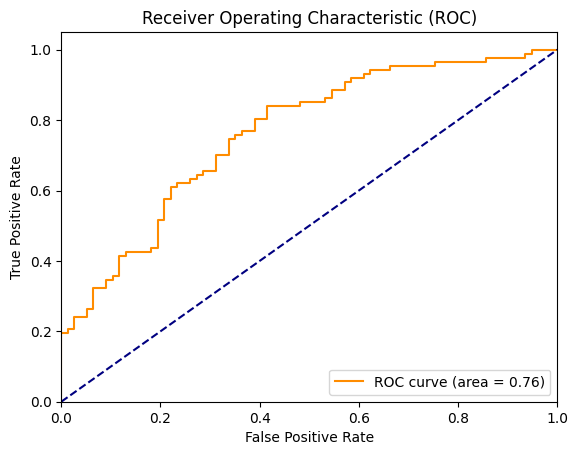

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming the model and test dataset is already defined
all_y = []
all_yhat = []

# Collecting ground truth and predictions
for batch in test_sub.as_numpy_iterator():
    X, y = batch
    yhat = model_sub.predict(X)
    all_y.extend(y)
    all_yhat.extend(yhat)

# Convert to arrays
all_y = np.array(all_y).ravel()
all_yhat = np.array(all_yhat).ravel()

# Check the lengths
if len(all_y) != len(all_yhat):
    min_len = min(len(all_y), len(all_yhat))
    all_y = all_y[:min_len]
    all_yhat = all_yhat[:min_len]

# Filter out abnormal values
finite_indices = np.where(np.isfinite(all_y) & np.isfinite(all_yhat))
all_y = all_y[finite_indices]
all_yhat = all_yhat[finite_indices]

# Compute ROC and AUC
fpr, tpr, thresholds = roc_curve(all_y, all_yhat)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()



---

# Experimental Sets with pre-loaded weights (Transfer Learning)

In [ ]:
#train_full
#val_full
#test_full
#train_sub
#val_sub
#test_sub

In [ ]:
# TensorFlow libraries
import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# basic libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

import glob
from glob import glob

In [ ]:
# Create a Sequential model
ResNet50 = ResNet50V2(weights = 'imagenet', input_shape = (256, 256, 3), include_top = False, classes=2)

model_RN50_Full = Sequential()
model_RN50_Full.add(ResNet50)
model_RN50_Full.add(GlobalAveragePooling2D())
model_RN50_Full.add(Dense(256, activation = 'relu', kernel_regularizer=regularizers.l2(0.02),kernel_constraint=max_norm(4)))
model_RN50_Full.add(Dropout(0.6))
model_RN50_Full.add(Dense(1, activation = 'sigmoid'))


adam = Adam(learning_rate=0.00001)
model_RN50_Full.compile(optimizer=adam, loss=tf.losses.BinaryCrossentropy(), metrics=['Recall','Precision','accuracy', 'AUC'])

In [ ]:
model_RN50_Full.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 24089601 (91.89 MB)
Trainable params: 24044161 (91.72 MB)
Non-trainable params: 45440 (177.50 KB)
________

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode ='min', patience=2, start_from_epoch=20)
hist3 = model_RN50_Full.fit(train_full, epochs=150, validation_data=val_full, callbacks=[callback],verbose=0)

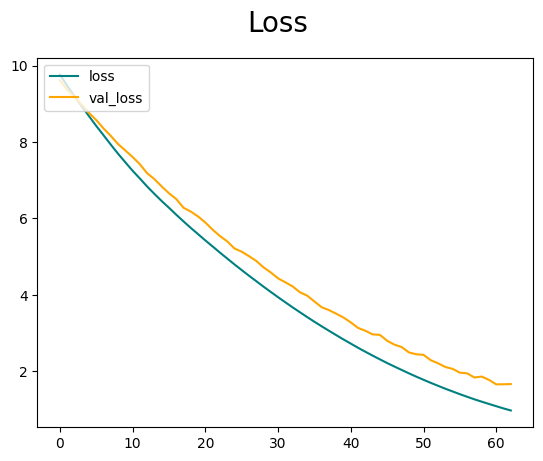

In [ ]:
fig = plt.figure()
plt.plot(hist3.history['loss'], color='teal', label='loss')
plt.plot(hist3.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()


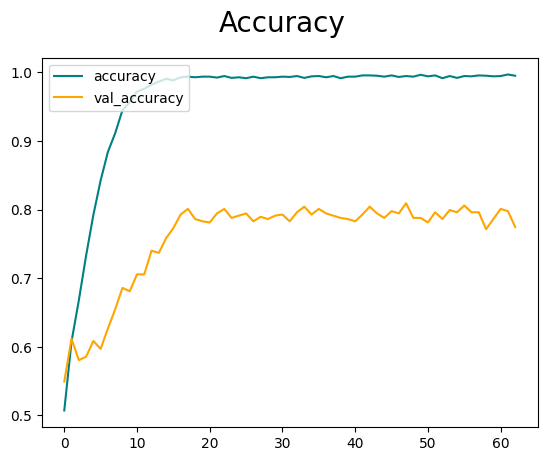

In [ ]:
fig = plt.figure()
plt.plot(hist3.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist3.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

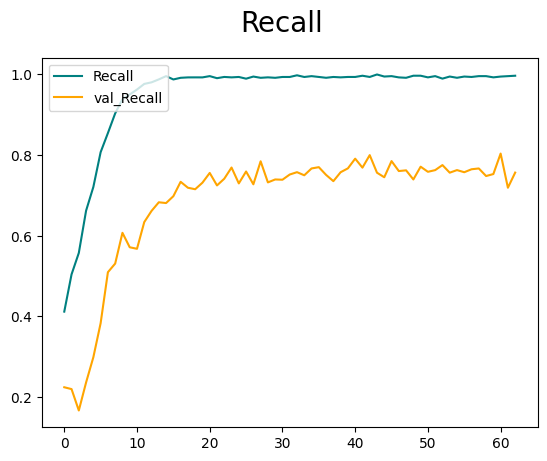

In [ ]:
fig = plt.figure()
plt.plot(hist3.history['recall'], color='teal', label='Recall')
plt.plot(hist3.history['val_recall'], color='orange', label='val_Recall')
fig.suptitle('Recall', fontsize=20)
plt.legend(loc="upper left")
plt.show()

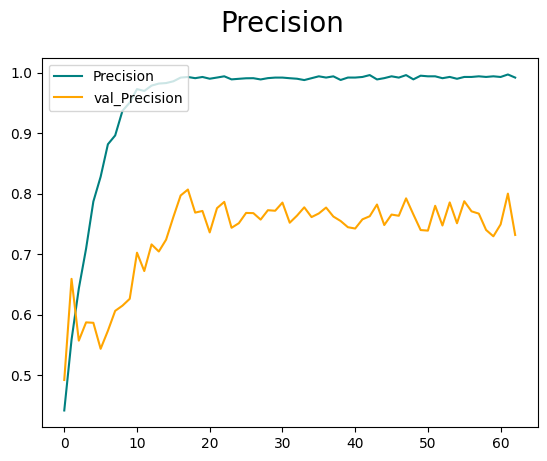

In [ ]:
fig = plt.figure()
plt.plot(hist3.history['precision'], color='teal', label='Precision')
plt.plot(hist3.history['val_precision'], color='orange', label='val_Precision')
fig.suptitle('Precision', fontsize=20)
plt.legend(loc="upper left")
plt.show()

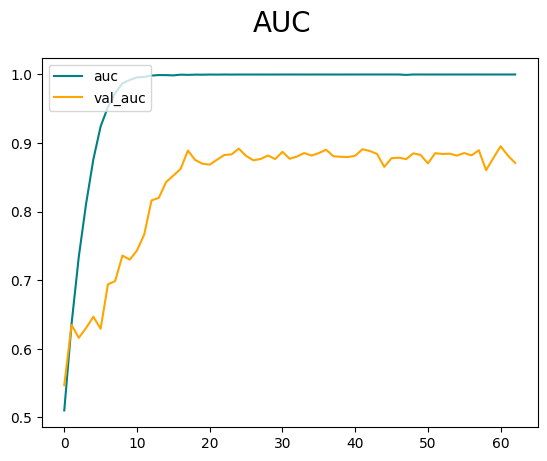

In [ ]:
fig = plt.figure()
plt.plot(hist3.history['auc'], color='teal', label='auc')
plt.plot(hist3.history['val_auc'], color='orange', label='val_auc')
fig.suptitle('AUC', fontsize=20)
plt.legend(loc="upper left")
plt.show()

1/1 [==============================] - 2s 2s/step


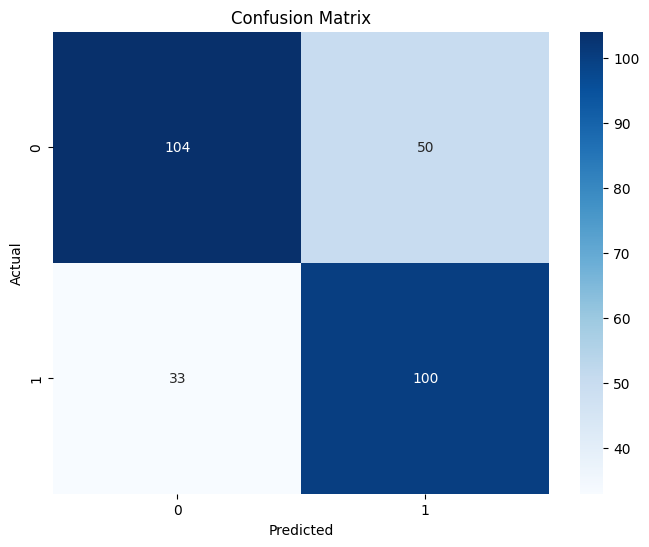

              precision    recall  f1-score   support

           0       0.76      0.68      0.71       154
           1       0.67      0.75      0.71       133

    accuracy                           0.71       287
   macro avg       0.71      0.71      0.71       287
weighted avg       0.72      0.71      0.71       287



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Initialize lists to store true labels and predictions
true_labels = []
predicted_labels = []

for batch in test_full.as_numpy_iterator():
    X, y = batch
    yhat = model_RN50_Full.predict(X)
    yhat_binary = (yhat > 0.5).astype(int)  # Binarize predictions using 0.5 as threshold

    true_labels.extend(y)
    predicted_labels.extend(yhat_binary)

# Generate and display the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Generate and print the classification report
report = classification_report(true_labels, predicted_labels)
print(report)


1/1 [==============================] - 0s 34ms/step


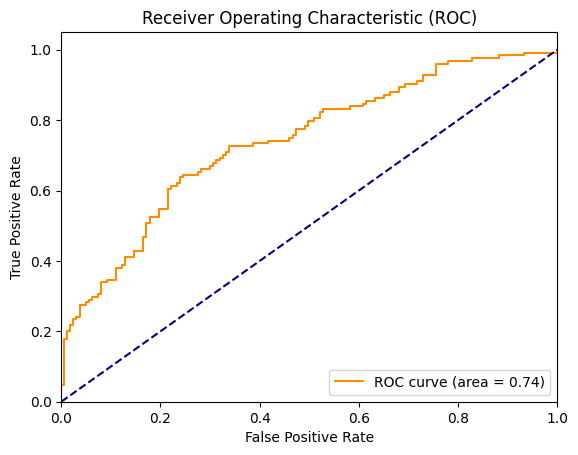

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming the model and test dataset is already defined
all_y = []
all_yhat = []

# Collecting ground truth and predictions
for batch in test_full.as_numpy_iterator():
    X, y = batch
    yhat = model_RN50_Full.predict(X)
    all_y.extend(y)
    all_yhat.extend(yhat)

# Convert to arrays
all_y = np.array(all_y).ravel()
all_yhat = np.array(all_yhat).ravel()

# Check the lengths
if len(all_y) != len(all_yhat):
    min_len = min(len(all_y), len(all_yhat))
    all_y = all_y[:min_len]
    all_yhat = all_yhat[:min_len]

# Filter out abnormal values
finite_indices = np.where(np.isfinite(all_y) & np.isfinite(all_yhat))
all_y = all_y[finite_indices]
all_yhat = all_yhat[finite_indices]

# Compute ROC and AUC
fpr, tpr, thresholds = roc_curve(all_y, all_yhat)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()



---

# Subset w/ Resnet50

In [ ]:
# Create a Sequential model
ResNet50 = ResNet50V2(weights = 'imagenet', input_shape = (256, 256, 3), include_top = False, classes=2)

model_RN50_sub = Sequential()
model_RN50_sub.add(ResNet50)
model_RN50_sub.add(GlobalAveragePooling2D())
model_RN50_sub.add(Dense(256, activation = 'relu', kernel_regularizer=regularizers.l2(0.02),kernel_constraint=max_norm(4)))
model_RN50_sub.add(Dropout(0.6))
model_RN50_sub.add(Dense(1, activation = 'sigmoid'))

adam = Adam(learning_rate=0.00001)
model_RN50_sub.compile(optimizer=adam, loss=tf.losses.BinaryCrossentropy(), metrics=['Recall','Precision','accuracy', 'AUC'])

In [ ]:
model_RN50_sub.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 127, 127, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                        

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode ='min', patience=2, start_from_epoch=20)
hist4 = model_RN50_sub.fit(train_sub, epochs=150, validation_data=val_sub, callbacks=[callback],verbose=0)

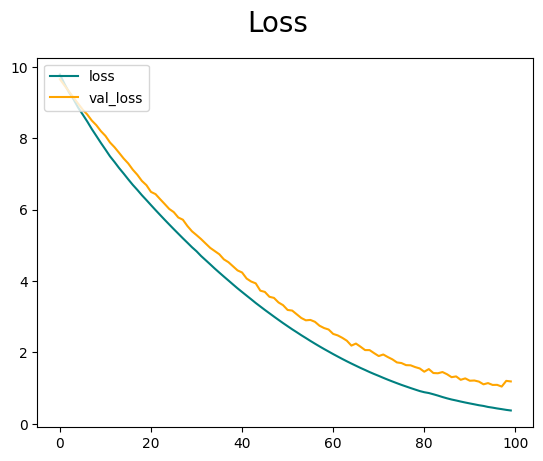

In [ ]:
fig = plt.figure()
plt.plot(hist4.history['loss'], color='teal', label='loss')
plt.plot(hist4.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()


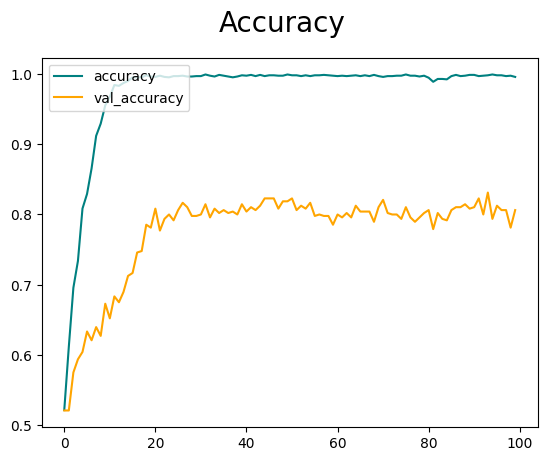

In [ ]:
fig = plt.figure()
plt.plot(hist4.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist4.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

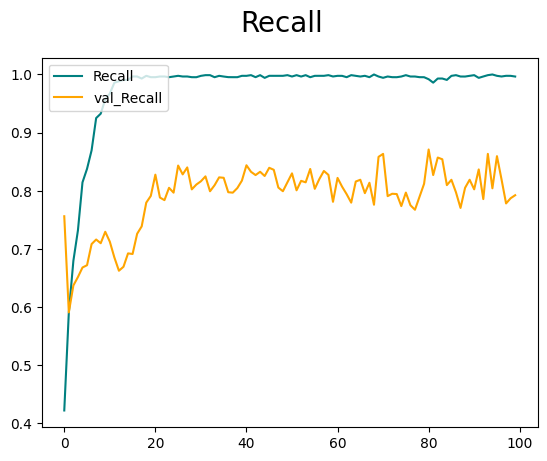

In [ ]:
fig = plt.figure()
plt.plot(hist4.history['recall'], color='teal', label='Recall')
plt.plot(hist4.history['val_recall'], color='orange', label='val_Recall')
fig.suptitle('Recall', fontsize=20)
plt.legend(loc="upper left")
plt.show()

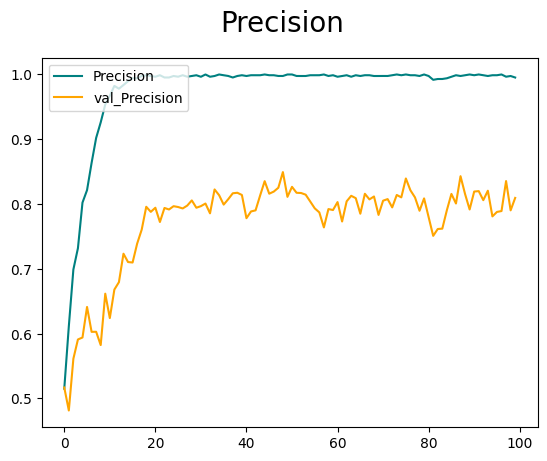

In [ ]:
fig = plt.figure()
plt.plot(hist4.history['precision'], color='teal', label='Precision')
plt.plot(hist4.history['val_precision'], color='orange', label='val_Precision')
fig.suptitle('Precision', fontsize=20)
plt.legend(loc="upper left")
plt.show()

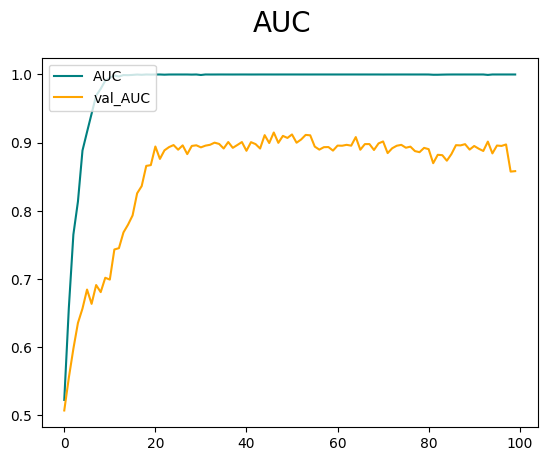

In [ ]:
fig = plt.figure()
plt.plot(hist4.history['auc'], color='teal', label='AUC')
plt.plot(hist4.history['val_auc'], color='orange', label='val_AUC')
fig.suptitle('AUC', fontsize=20)
plt.legend(loc="upper left")
plt.show()

1/1 [==============================] - 2s 2s/step


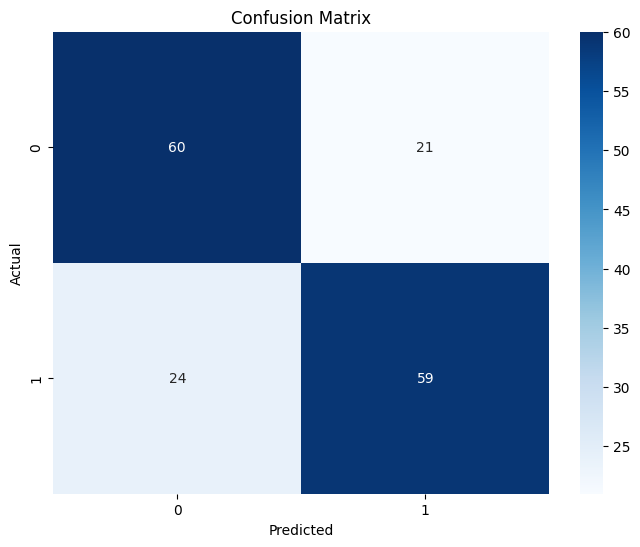

              precision    recall  f1-score   support

           0       0.71      0.74      0.73        81
           1       0.74      0.71      0.72        83

    accuracy                           0.73       164
   macro avg       0.73      0.73      0.73       164
weighted avg       0.73      0.73      0.73       164



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Initialize lists to store true labels and predictions
true_labels = []
predicted_labels = []

for batch in test_sub.as_numpy_iterator():
    X, y = batch
    yhat = model_RN50_sub.predict(X)
    yhat_binary = (yhat > 0.5).astype(int)  # Binarize predictions using 0.5 as threshold

    true_labels.extend(y)
    predicted_labels.extend(yhat_binary)

# Generate and display the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Generate and print the classification report
report = classification_report(true_labels, predicted_labels)
print(report)


1/1 [==============================] - 0s 25ms/step


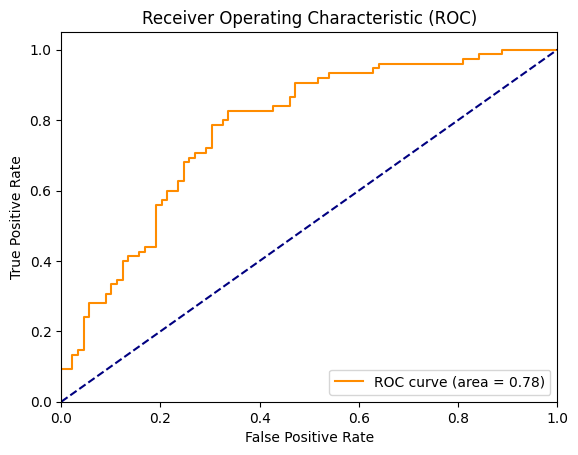

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming the model and test dataset is already defined
all_y = []
all_yhat = []

# Collecting ground truth and predictions
for batch in test_sub.as_numpy_iterator():
    X, y = batch
    yhat = model_RN50_sub.predict(X)
    all_y.extend(y)
    all_yhat.extend(yhat)

# Convert to arrays
all_y = np.array(all_y).ravel()
all_yhat = np.array(all_yhat).ravel()

# Check the lengths
if len(all_y) != len(all_yhat):
    min_len = min(len(all_y), len(all_yhat))
    all_y = all_y[:min_len]
    all_yhat = all_yhat[:min_len]

# Filter out abnormal values
finite_indices = np.where(np.isfinite(all_y) & np.isfinite(all_yhat))
all_y = all_y[finite_indices]
all_yhat = all_yhat[finite_indices]

# Compute ROC and AUC
fpr, tpr, thresholds = roc_curve(all_y, all_yhat)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()